In [1]:
# Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns
from explore import xgb_rank

# Feature Selection
from explore import get_scaled_df
import xgboost as xgb
from sklearn.decomposition import PCA

# Evaluate Algorithms

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data

import model
from model import polynomial_regression_model
from model import run_models

import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import sys 

**Let's bring in the DataFrame**

In [3]:
df = acquire_oil()
df = prep_data(df)

**(Rows, Columns)**

In [4]:
df.shape

(7808, 60)

In [5]:
df.columns

Index(['api14', 'lease_name', 'well_number', 'county', 'direction', 'status',
       'oper', 'multi_well_lease', 'major_phase', 'formation', 'proppant_ppf',
       'prod_method', 'frac_fluid_gpf', 'gross_perfs', 'frac_stages',
       'frac_fluid_type', 'first_prod', 'last_prod', 'oil_gravity',
       'peak_boepd', 'oil_hist', 'gas_hist', 'gor_hist', 'ip90_boeqpd', 'tvd',
       'sur_lat', 'sur_long', 'well_id', 'mid_point_lat', 'mid_point_long',
       'sub_basin', 'recovery', 'recovery_per_foot', 'months_active',
       'recovery_per_month', 'lateral_class', 'vintage', 'vintage_bin',
       'encoded_direction', 'encoded_frac_fluid_type', 'encoded_county',
       'encoded_oper', 'encoded_formation', 'encoded_lateral_class',
       'scaled_direction', 'scaled_frac_fluid_type', 'scaled_county',
       'scaled_oper', 'scaled_formation', 'scaled_lateral_class',
       'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs',
       'scaled_frac_stages', 'scaled_oil_gravity', 's

### XGBoost Feature Recommender

In [6]:
feature_list, scaled_features, importance_df = xgb_rank(df,df.recovery,feature_percent=80,mode='gain')
feature_list

['oil_gravity',
 'tvd',
 'vintage',
 'gross_perfs',
 'mid_point_lat',
 'mid_point_long',
 'direction']

In [7]:
scaled_features

['scaled_oil_gravity',
 'scaled_tvd',
 'scaled_vintage',
 'scaled_gross_perfs',
 'scaled_mid_point_lat',
 'scaled_mid_point_long',
 'scaled_direction']

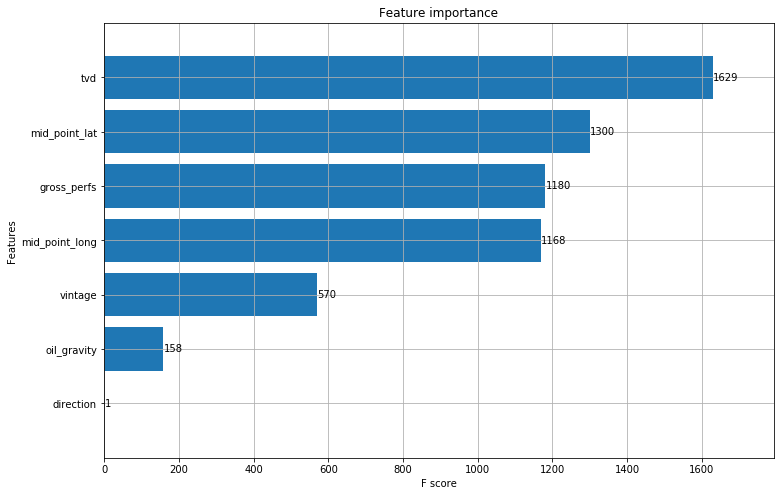

In [8]:
xgb_df = get_scaled_df(df).drop(columns=['recovery'])
xgb_df = xgb_df[feature_list]

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}

dtrain = xgb.DMatrix(xgb_df, df.oil_hist, feature_names=xgb_df.columns.values)
xgb_model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(xgb_model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [9]:
importance_df

,rank,feature,gain,cum_sum,cum_perc
0,1.0,oil_gravity,175754.50,175754.50,29.53
1,2.0,tvd,92826.75,268581.25,45.13
2,3.0,vintage,67844.76,336426.01,56.53
3,4.0,gross_perfs,39749.01,376175.02,63.21
4,5.0,mid_point_lat,36476.05,412651.07,69.34
5,6.0,mid_point_long,30961.20,443612.27,74.54
6,7.0,direction,23154.78,466767.05,78.43
7,8.0,frac_fluid_gpf,19822.03,486589.08,81.76
8,9.0,frac_stages,19517.30,506106.38,85.04
9,10.0,oper,16058.74,522165.12,87.74


In [10]:
sorted_list = ['oil_gravity', 'tvd', 'vintage', 'gross_perfs', 'mid_point_lat', 'mid_point_long', 'direction']

<BarContainer object of 7 artists>

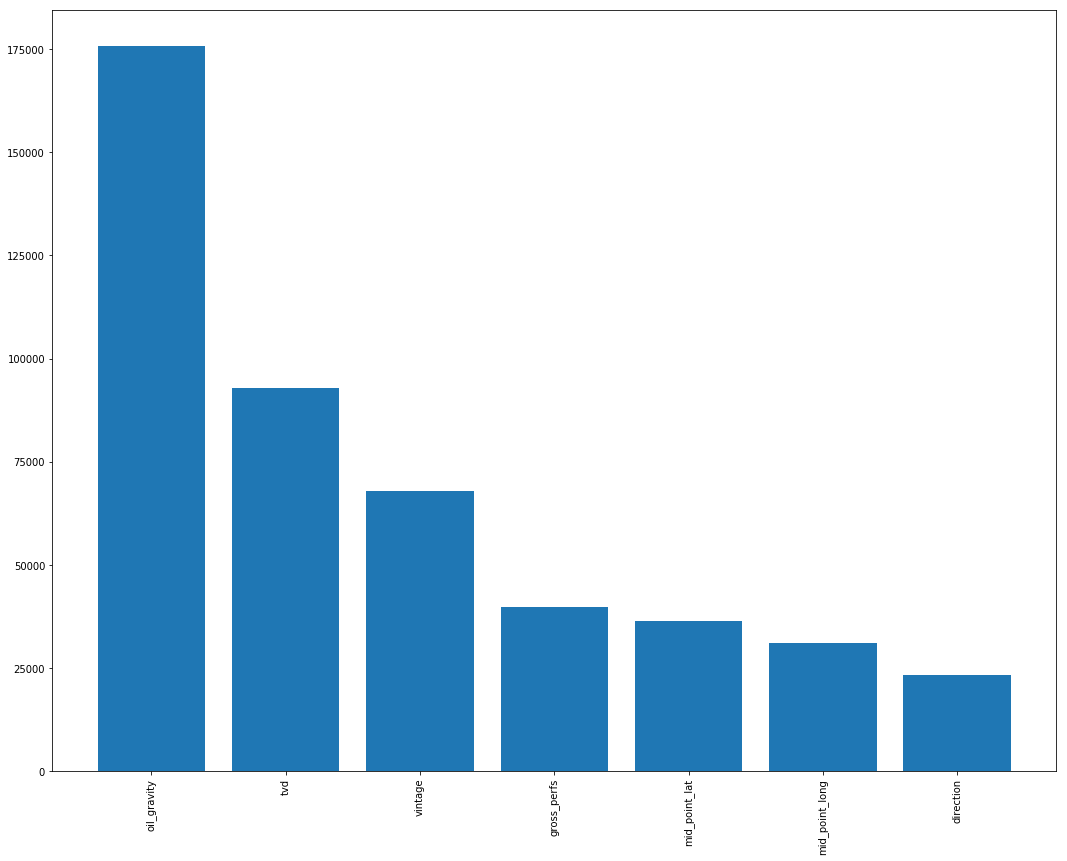

In [11]:
plt.figure(figsize = (18,14))
plt.xticks(rotation=90)
plt.rc('xtick',labelsize=30)
plt.rc('ytick',labelsize=25)
plt.bar(importance_df.feature[:7], importance_df.gain[:7])

# Test Harness and Options

### Results for the entire dataframe to use as a baseline before clustering

In [12]:
feature_list

['oil_gravity',
 'tvd',
 'vintage',
 'gross_perfs',
 'mid_point_lat',
 'mid_point_long',
 'direction']

In [13]:
xfeatures = ['oil_gravity', 'tvd', 'vintage', 'gross_perfs', 'mid_point_lat', 'mid_point_long', 'encoded_direction'] 
yfeature = ['recovery']

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 101.94359040398794
R2 score of training set is 0.3170431239300544


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.27696508 0.31689793 0.34903832]


The model performance for the test set
-------------------------------------------
RMSE of test set is 101.06257931937142
R2 score of test set is 0.29744474840705204




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 101.85627204124039
R2 score of training set is 0.31821257727937513


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.27879799 0.31763348 0.34977165]


The model performance for the test set
-------------------------------------------
RMSE of test set is 1

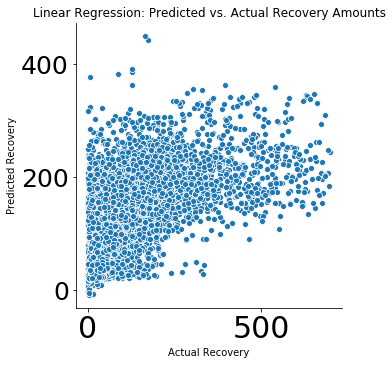

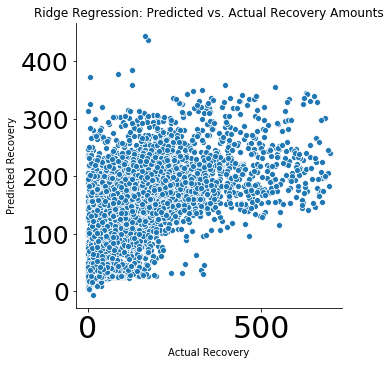

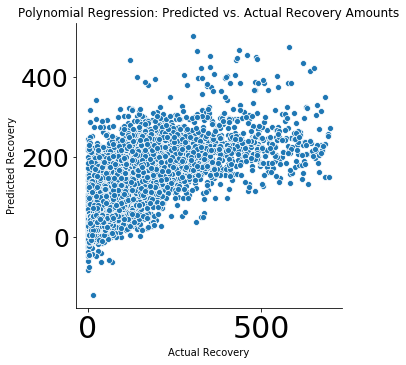

In [14]:
model.run_models(df, xfeatures, yfeature, 0.80)

**Let's Cluster by our Top Seven features per our XGBoost function**

In [15]:
feature_list

['oil_gravity',
 'tvd',
 'vintage',
 'gross_perfs',
 'mid_point_lat',
 'mid_point_long',
 'direction']

In [16]:
scaled_features

['scaled_oil_gravity',
 'scaled_tvd',
 'scaled_vintage',
 'scaled_gross_perfs',
 'scaled_mid_point_lat',
 'scaled_mid_point_long',
 'scaled_direction']

#### Had to use encoded_direction:

In [17]:
col_list = scaled_features

**We now have a new dataframe with an added column "cluster_id"**

In [18]:
df = model.create_kclusters(df, col_list, 3, 'cluster_id')

**Let's see how many oberservations we have in each cluster**

In [19]:
df.cluster_id.value_counts()

2    4790
0    1805
1    1213
Name: cluster_id, dtype: int64

In [20]:
df.to_excel('CapstoneDataFinal.xlsx')

# ALL Regression Types on Each Cluster

### Cluster 0: 4,019 Oberservations -- observation count did not change

In [21]:
cluster_zero = df[df['cluster_id'] == 0]

In [22]:
cluster_zero.shape

(1805, 61)

In [23]:
feature_list, scaled_features, importance_df = xgb_rank(cluster_zero,cluster_zero.recovery,feature_percent=80,mode='gain')
feature_list

['mid_point_long',
 'vintage',
 'oper',
 'mid_point_lat',
 'tvd',
 'gor_hist',
 'gross_perfs']

#### Had to use encoded_formation.

In [24]:
xfeatures = ['oil_gravity', 'vintage', 'gross_perfs', 'mid_point_lat', 'mid_point_long']
yfeature = ['recovery']

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 132.21813659099345
R2 score of training set is 0.03563277301471279


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [ 0.09044189 -0.0726559   0.02393529]


The model performance for the test set
-------------------------------------------
RMSE of test set is 134.12759602633702
R2 score of test set is 0.071000230286967




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 115.58772794430521
R2 score of training set is 0.26297226209902935


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.28545925 0.18006132 0.26794516]


The model performance for the test set
-------------------------------------------
RMSE of test set is

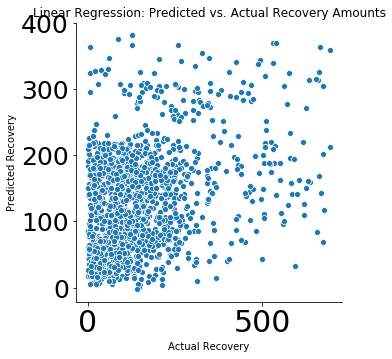

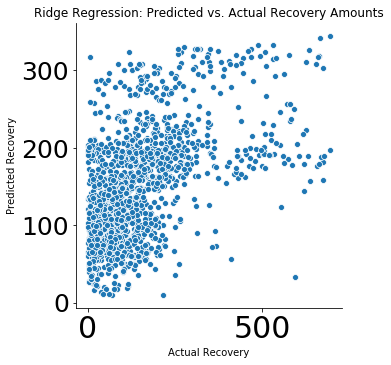

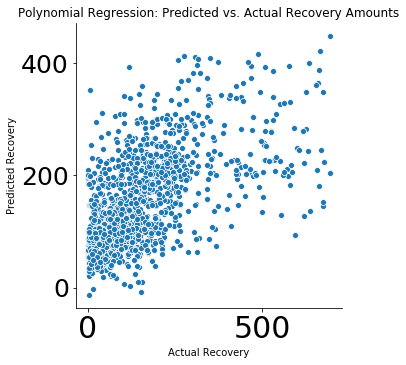

In [25]:
model.run_models(cluster_zero, xfeatures, yfeature, 0.70)

### Cluster 1:  1,224 Observations, down from 1,714 Observations

In [26]:
cluster_one = df[df['cluster_id'] == 1]

In [27]:
cluster_one.shape

(1213, 61)

In [28]:
feature_list, scaled_features, importance_df = xgb_rank(cluster_one,cluster_one.recovery,feature_percent=80,mode='gain')
feature_list

['vintage', 'gor_hist', 'tvd', 'gross_perfs', 'mid_point_long', 'formation']

#### Had to use encoded_lateral_class and encoded_formation.

In [29]:
xfeatures = ['vintage', 'encoded_direction', 'gross_perfs', 'encoded_formation', 'gor_hist', 'mid_point_long', 'tvd']
yfeature = ['recovery']

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 33.96362461379776
R2 score of training set is 0.3159943882117545


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.3256323  0.27800862 0.29311508]


The model performance for the test set
-------------------------------------------
RMSE of test set is 30.8692203984802
R2 score of test set is 0.17584519858358638




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 33.964238092117355
R2 score of training set is 0.3159696778689767


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.32553613 0.27758663 0.29573462]


The model performance for the test set
-------------------------------------------
RMSE of test set is 30.82

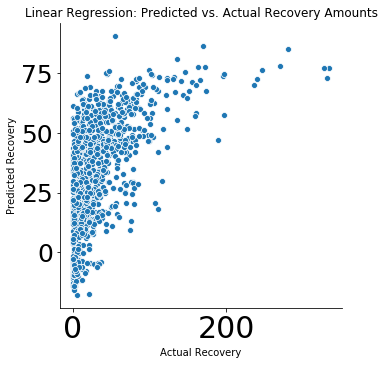

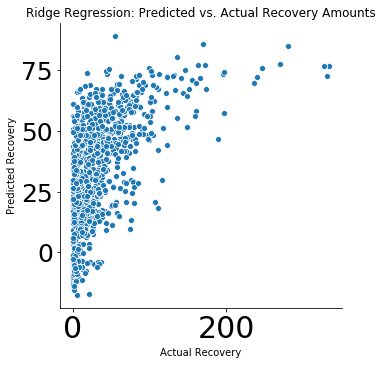

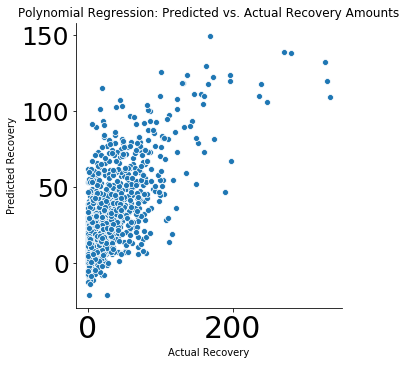

In [30]:
model.run_models(cluster_one, xfeatures, yfeature, 0.70)

### Cluster 2: 2,565 Observations, up from 1,232 Observations

In [31]:
cluster_two = df[df['cluster_id'] == 2]

In [32]:
cluster_two.shape

(4790, 61)

In [33]:
feature_list, scaled_features, importance_df = xgb_rank(cluster_two,cluster_two.recovery,feature_percent=80,mode='gain')
feature_list

['oil_gravity',
 'vintage',
 'gross_perfs',
 'mid_point_lat',
 'mid_point_long',
 'tvd']

#### Did not have to encode any of these features.

In [34]:
xfeatures = ['mid_point_long', 'vintage', 'encoded_oper', 'mid_point_lat', 'gross_perfs', 'gor_hist', 'tvd', 'oil_gravity']
yfeature = ['recovery']

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 103.76410704543751
R2 score of training set is 0.18796905959025134


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.17726556 0.21366955 0.16408739]


The model performance for the test set
-------------------------------------------
RMSE of test set is 107.44072664814738
R2 score of test set is 0.18587921242726113




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 103.69496420755846
R2 score of training set is 0.18905088680161286


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.17828206 0.21147619 0.16620195]


The model performance for the test set
-------------------------------------------
RMSE of test set is 

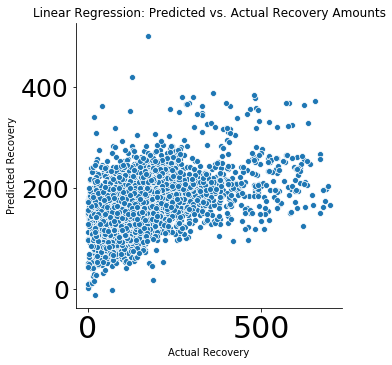

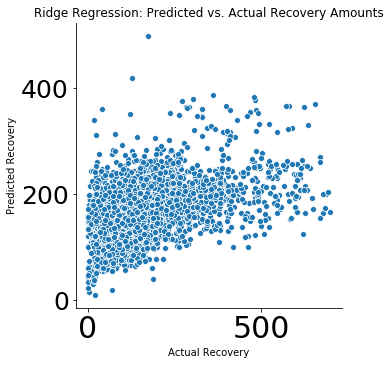

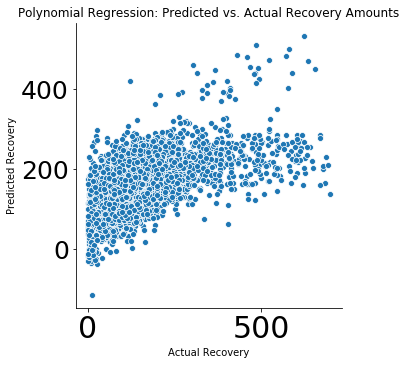

In [35]:
model.run_models(cluster_two, xfeatures, yfeature, 0.70)

## Interpret and report results

# Improve Results

## Algorithm Tuning

## Ensemble Methods

### Bagging

### Boosting

### Blending

## Extreme Feature Engineering